In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Timestamp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [ ]:
!pip install keras-tuner -q
import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
#Dataset of minimum phase
#https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_minimum.csv'

#Dataset of rising phase
uri='https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_rising.csv'

#Dataset of CME event
#https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_CME.csv'

#Dataset of quiet event
#https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_Quiet.csv'

#Dataset of SIR-HSS event
#https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_SIR-HSS.csv'

#Dataset of CME-CME event
#uri='https://raw.githubusercontent.com/PatapongPanpiboon/thermospheric-density/main/IMF_CME_CME.csv'

df=pd.read_csv(uri)
df.head()

,Date,SymH,Density,SymH_Norm,Density_Norm,ap60,F107,MgII,ap60_Norm,F107_Norm,MgII_Norm,imf_DNS_1,imf_DNS_2,imf_DNS_3,imf_DNS_4,imf_DNS_5,imf_DNS_6,imf_DNS_7,imf_DNS_8,imf_DNS_9
0,2020-09-16 00:00:00,-18,3.648273e-14,0.282158,0.020104,6,69.7,0.274066,0.028986,0.378804,0.971796,-0.000340,0.000544,-0.000114,0.004535,0.000088,0.000654,-0.008735,-0.020550,0.044023
1,2020-09-16 01:00:00,-16,4.164481e-14,0.273859,0.023115,6,69.7,0.274066,0.028986,0.378804,0.971796,0.003408,-0.000693,0.000152,0.004771,0.000097,0.000600,-0.008714,-0.020531,0.044025
2,2020-09-16 02:00:00,-14,3.170736e-14,0.265560,0.017319,4,69.7,0.274066,0.019324,0.378804,0.971796,-0.003209,-0.000521,0.000605,0.004971,0.000105,0.000547,-0.008693,-0.020512,0.044027
3,2020-09-16 03:00:00,-13,4.514917e-14,0.261411,0.025159,5,69.7,0.274066,0.024155,0.378804,0.971796,0.002751,0.000660,0.001145,0.005134,0.000111,0.000494,-0.008672,-0.020492,0.044029
4,2020-09-16 04:00:00,-12,4.395025e-14,0.257261,0.024460,3,69.7,0.274066,0.014493,0.378804,0.971796,0.000528,0.001539,0.001674,0.005256,0.000115,0.000441,-0.008650,-0.020473,0.044031


In [ ]:
#Setting input data of minimum phase
'''cols =  ['Date','Density','SymH','ap60','F107','MgII',
         'F107_Norm','MgII_Norm',
        'imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9', 'imf_DNS_10', 'imf_DNS_11']'''

#Setting input data of rising phase
cols = ['Date','Density','SymH','ap60','F107','MgII',
        'imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9']

#Setting input data of CME, quiet, SIR-HSS event
'''cols = ['Date','Density','SymH','ap60','F107','MgII',
         'F107_Norm','MgII_Norm',
        'imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7']'''

#Setting input data of CME-CME event
'''cols = ['Date','Density','SymH','ap60','F107','MgII',
        'imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8']'''

df_Norm = df.drop(columns = cols)
df_Norm  = df_Norm /df_Norm .max()
x_data = df_Norm.to_numpy()

print(x_data.shape)

(19944, 8)


In [ ]:
#Setting obsevation data of minimum phase
'''cols = ['Date','Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9', 'imf_DNS_10', 'imf_DNS_11']'''

#Setting obsevation data of rising phase
cols = ['Date','Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9']

#Setting obsevation data of CME, quiet, SIR-HSS event
'''cols = ['Date','Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7']'''

#Setting obsevation data of CME-CME event
'''cols = ['Date','Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8']'''

df2 = df.drop(columns = cols)
Y_data = df2.to_numpy()

print(Y_data.shape)

(19944, 1)


In [ ]:
x = x_data
Y = Y_data
# generate the training and test sequences
n_forecast = 1

# Lookback hour prediction of minimum and rising phase
n_lookback = 12

# Lookback hour prediction  of four case study
'''n_lookback = 4'''

X = []
y = []

for i in range(n_lookback, len(x) - n_forecast + 1):
    X.append(x[i - n_lookback: i])
    y.append(Y[i: i + n_forecast])

X = np.array(X)
y = np.array(y)

In [ ]:
# train and test model split of minimum and rising phase
n_train = int(len(X)*0.75)
n_test = len(X)-n_train
X_train, X_test =X[0:n_train], X[n_train:len(X)]
y_train, y_test = y[0:n_train], y[n_train:len(y)]
print(X_train.shape, X_test.shape)

# train and test model split of four case study
'''n_train = int(len(X)*0.7994)
n_test = len(X)-n_train
X_train, X_test =X[0:n_train], X[n_train:len(X)]
y_train, y_test = y[0:n_train], y[n_train:len(y)]
print(X_train.shape, X_test.shape)'''

(14949, 12, 8) (4983, 12, 8)


In [ ]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

y_train, y_test = y[0:n_train], y[n_train:len(y)]
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y = y.reshape(-1,1)
print(y_train.shape, y_test.shape)

(14949, 1) (4983, 1)


In [ ]:
epochs = 500
learning_rate= 0.001

#Batch size setting of minimum and rising phase
batch_size = int(X_train.shape[0]/9)

#Batch size setting of four case study
'''batch_size = 1+int(X_train.shape[0]/4)'''

print(batch_size)

1661


In [ ]:
# Define a function to build the GRU model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Choice('gru_units',
                                values = [64, 128, 256, 512]),
                                activation = 'relu',
                                input_shape=(n_steps, n_features)))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.2, step=0.1)))
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate),
                                loss='mean_squared_error')
    model.fit(X_train , y_train, epochs = epochs, batch_size = batch_size,
                                validation_data=(X_test, y_test), verbose=0)
    return model

In [ ]:
# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
)

In [ ]:
# Start hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stopping])
tuner.results_summary(1)

Trial 30 Complete [00h 01m 46s]
val_loss: 0.0020131636410951614

Best val_loss So Far: 0.0012421796564012766
Total elapsed time: 01h 00m 24s
Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 27 summary
Hyperparameters:
gru_units: 64
dropout: 0.0
Score: 0.0012421796564012766


Copy best value of gru_units and dropout. Paste next cell and run.

In [ ]:
gru_units= 64
dropout= 0.0

####
model = Sequential()
model.add(GRU(gru_units,
                    activation = 'relu',
                    input_shape = (n_steps, n_features)))
model.add(tf.keras.layers.Dropout(dropout))
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = Adam(learning_rate),
                    loss='mean_squared_error')
# Train the model
ht = model.fit(X_train, y_train, epochs = epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose = 0)

156/156 [==============================] - 2s 10ms/step - loss: 0.0010


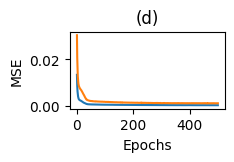

In [ ]:
# Evaluate the final model
mse = model.evaluate(X_test, y_test)
plt.figure(figsize=(2,1))
plt.plot(ht.history['loss'], label='Training')
plt.plot(ht.history['val_loss'], label='Validation')
plt.title(f"(d)")
#plt.legend(edgecolor='white', loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

156/156 [==============================] - 1s 4ms/step


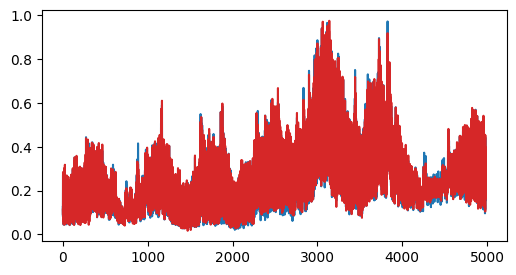

In [ ]:
Z1 = model.predict(X_test)
plt.figure(figsize=(6,3))
plt.plot(y_test, 'tab:blue')
plt.plot(Z1, 'tab:red')
plt.show()

623/623 [==============================] - 2s 4ms/step


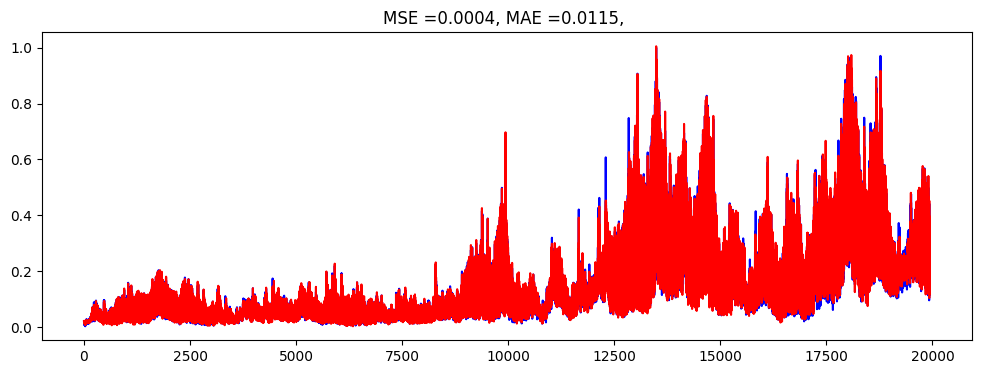

In [ ]:
Z2 = model.predict(X)
plt.figure(figsize=(12,4))
plt.plot(y, 'b')
plt.plot(Z2, 'r')
mse = mean_squared_error(y, Z2)
mae = mean_absolute_error(y, Z2)
plt.title("MSE ="+f"{mse:.4f}, "+"MAE ="+f"{mae:.4f}, ")
plt.show()

In [ ]:
rho_max = df['Density'].max()
print('Density = {:.9}'.format(rho_max))

y_plot = y_test
y_syn_plot = Z1
y_true  = y_plot*rho_max
y_pred = y_syn_plot*rho_max

#NRMSE
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
NRMSE = RMSE/(np.max(y_true) - np.min(y_true))
print('NRMSE = {:.2%}'.format(NRMSE))

#R_SQURE
R_SQURE = r2_score(y_true, y_pred)
print('R_SQURE = {:.3f}'.format(R_SQURE))

Density = 1.71652203e-12
NRMSE = 3.35%
R_SQURE = 0.957


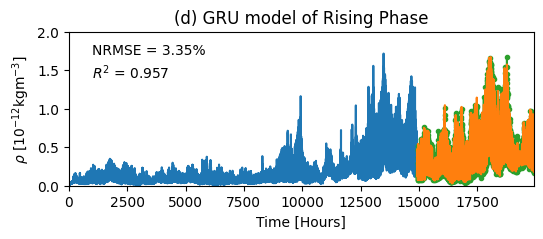

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 2))

ax.plot(np.arange(0, len(y_train)), rho_max*y_train*1e12, color = 'tab:blue', label = "Training ")
ax.plot(np.arange(len(y_train), len(y_train)+len(y_test)), rho_max*y_test*1e12, 'tab:green', marker = '.', label = "Validation")
ax.plot(np.arange(len(y_train), len(y_train)+len(y_test)), rho_max*Z1*1e12,  color = 'tab:orange', label = "Prediction")

ax.set_ylim(0,2.0)
ax.set_ylabel(r'$\rho$' " [$\mathregular{10^{-12} kgm^{-3}}$]")
ax.set_xlabel('Time [Hours]')
ax.text(7500, 1.7, 'NRMSE = {:.2%}'.format(NRMSE), size=10)
ax.text(7500, 1.4, '$R^2$ = {:.3f}'.format(R_SQURE), size=10)

ax.set_title('(d) GRU model of Rising Phase', loc='center')
ax.margins(0, 0)
plt.legend(edgecolor='white', loc='upper left')
plt.show()

In [ ]:
model = LinearRegression()
model.fit(y_true, y_pred)
linear = model.predict(y_true)

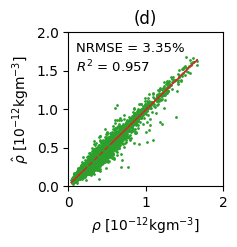

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.scatter(y_true*1e12, y_pred*1e12, s = 1, color = 'tab:green')
ax.plot(y_true*1e12, linear*1e12, linewidth = '1', linestyle  = '--', color = 'tab:red')
ax.set_xlim(0.0,2.0)
ax.set_ylim(0.0,2.0)
ax.set_title('(d)', loc='center')
ax.set_ylabel(r'$\hat{\rho}$' " [$\mathregular{10^{-12} kgm^{-3}}$]")
ax.set_xlabel(r'$\rho$' " [$\mathregular{10^{-12} kgm^{-3}}$]")

ax.text(0.1, 1.75, 'NRMSE = {:.2%}'.format(NRMSE), size=9.5)
ax.text(0.1, 1.48, '$R^2$ = {:.3f}'.format(R_SQURE), size=9.5)

plt.margins(0, 0)
plt.show()

In [ ]:
cols_syn = ['Density_syn']
dfTest = pd.DataFrame(Z2,columns=cols_syn)

#Setting obsevation data of minimum phase
'''cols = ['Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9', 'imf_DNS_10', 'imf_DNS_11']'''

#Setting obsevation data of rising phase
cols = ['Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8','imf_DNS_9']

#Setting obsevation data of CME, quiet, SIR-HSS event
'''cols = ['Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7']'''

#Setting obsevation data of CME-CME event
'''cols = ['Density','SymH','ap60','F107','MgII',
        'SymH_Norm','ap60_Norm','F107_Norm','MgII_Norm',
        'imf_DNS_1','imf_DNS_2','imf_DNS_3','imf_DNS_4','imf_DNS_5',
        'imf_DNS_6','imf_DNS_7','imf_DNS_8']'''

df_model = df.drop(columns = cols)
df_model.Date=pd.to_datetime(df_model.Date)
df_model.set_index('Date', inplace=True)
df_model = df_model.loc['2020-09-16 12:00:00':'2022-12-25']
df_model = df_model.reset_index(drop=False)

print(dfTest.shape, df_model.shape)


(19932, 1) (19932, 2)


In [ ]:
dfTest.tail()

,Density_syn
19927,0.104082
19928,0.452130
19929,0.161621
19930,0.172523
19931,0.395034


In [ ]:
df_model[cols_syn]=dfTest[cols_syn]
df_model.head()

,Date,Density_Norm,Density_syn
0,2020-09-16 12:00:00,0.020689,0.021958
1,2020-09-16 13:00:00,0.016368,0.019033
2,2020-09-16 14:00:00,0.020975,0.021447
3,2020-09-16 15:00:00,0.018341,0.021879
4,2020-09-16 16:00:00,0.016376,0.022386


In [ ]:
df_model.tail()

,Date,Density_Norm,Density_syn
19927,2022-12-25 19:00:00,0.113219,0.104082
19928,2022-12-25 20:00:00,0.441447,0.452130
19929,2022-12-25 21:00:00,0.153908,0.161621
19930,2022-12-25 22:00:00,0.227383,0.172523
19931,2022-12-25 23:00:00,0.333054,0.395034


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
file_path = 'GRU_best_rising.csv'
df_model.to_csv(file_path)
!cp GRU_best_rising "drive/My Drive/"